In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.io

import mne
from scipy.signal import coherence, hilbert

In [2]:
def metricas_grafo(G):
    # Métricas:
    # (a) Clustering promedio (coeficiente de agrupamiento)
    clust_coeff = nx.average_clustering(G)
    # (b) Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan  # red no conexa
    # (c) Small-worldness (ejemplo simplificado)
    # Comparar con grafo aleatorio de igual N, K
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)
    
    # (d) Modularidad — usando método de comunidades
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)
    
    # (e) Hubs — grado, centralidad de intermediación
    degree_dict = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    
    # (f) Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict

In [3]:
eeg_coords_csv = r"..\..\S03_datasets\EEG_practica\coordenadas_bipolares_eeg.csv"
eeg_coords = pd.read_csv(eeg_coords_csv)

eeg_coords.set_index("canal", drop=True, inplace=True)

In [4]:
edf_path = r"..\..\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)

# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
eeg_data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\OMEN CI7\Documents\repository\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\OMEN CI7\AppData\Local\Temp\ipykernel_23856\4141082732.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [5]:
# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(eeg_data[i], eeg_data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

eeg_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
np.fill_diagonal(eeg_df.values, 0)

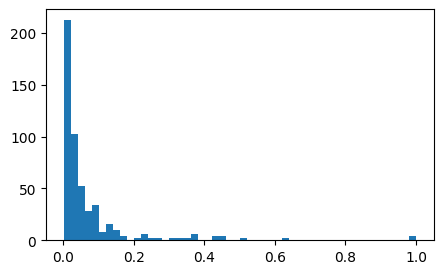

In [6]:
plt.figure(figsize=(5, 3))
plt.hist(eeg_df[eeg_df>0].values.flatten(), bins=50)
plt.show()

In [7]:
data = eeg_df[eeg_df>0].stack().values
p25, p50, p75, p100 = (np.percentile(data, 25), np.percentile(data, 50), np.percentile(data, 75), np.percentile(data, 100))

pd.Series(eeg_df[eeg_df>0].values.flatten()).describe()

count    506.000000
mean       0.068382
std        0.126917
min        0.001048
25%        0.009557
50%        0.029258
75%        0.068543
max        1.000000
dtype: float64

In [8]:
p25, p50, p75, p100

(np.float64(0.009556997457899724),
 np.float64(0.029258293695663715),
 np.float64(0.068543087357848),
 np.float64(0.9999999999999999))

In [9]:
# Generar grafo desde matriz
eeg_graph = nx.from_pandas_adjacency(eeg_df, create_using=nx.Graph())

clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph)

In [75]:
threshold = p75
eeg_df_filtered = eeg_df.where(eeg_df > threshold, 0)
eeg_df_ = eeg_df_filtered

eeg_graph = nx.from_pandas_adjacency(eeg_df_, create_using=nx.Graph())
clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph)

In [76]:
communities

[frozenset({'F7-T7',
            'F8-T8',
            'FP1-F3',
            'FP1-F7',
            'FP2-F4',
            'FP2-F8',
            'FT9-FT10',
            'T7-FT9'}),
 frozenset({'C3-P3', 'P3-O1', 'P4-O2', 'P7-O1', 'P8-O2'}),
 frozenset({'C4-P4', 'F3-C3', 'F4-C4', 'FT10-T8', 'FZ-CZ'}),
 frozenset({'CZ-PZ', 'P7-T7', 'T7-P7', 'T8-P8-0', 'T8-P8-1'})]

In [12]:
eeg_df.columns

Index(['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

In [64]:
def plots(ax_, degree_dict_, df, title):
    # Creamos el plot3D del grafo
    x, y, z = eeg_coords.loc[:, 'x'].values, eeg_coords.loc[:, 'y'].values, eeg_coords.loc[:, 'z'].values

    # DIBUJAR LOS NODOS
    sc = ax_.scatter(x, y, z, s=np.array(list(degree_dict.values()))*20, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
    ax.set_title(title)
    
    # DIBUJAR LAS ARISTAS
    segments = []
    weights = []
    colors = []
    
    G = nx.from_pandas_adjacency(df)
    for i, j, data in G.edges(data=True):
        x = [eeg_coords.loc[i, 'x'], eeg_coords.loc[j, 'x']]
        y = [eeg_coords.loc[i, 'y'], eeg_coords.loc[j, 'y']]
        z = [eeg_coords.loc[i, 'z'], eeg_coords.loc[j, 'z']]
    
        segment = np.column_stack([x, y, z])
        segments.append(segment)
    
        weights.append(data['weight'] * 4)
        colors.append(df.loc[i, j])
    
    # Convertir a arrays
    weights = np.array(weights)
    colors = np.array(colors)
    
    # Crear colección de líneas 3D
    lc = Line3DCollection(
        segments,
        linewidths=3, #weights,
        cmap='hot_r',
        norm=plt.Normalize(vmin=colors.min(), vmax=colors.max()),
        alpha=0.5
    )
    lc.set_array(colors)
    
    # Añadir al eje
    ax_.add_collection3d(lc)
    
    # Añadir colorbar
    cbar = plt.colorbar(lc, ax=ax_, shrink=0.5)
    cbar.set_label("Coactivación")


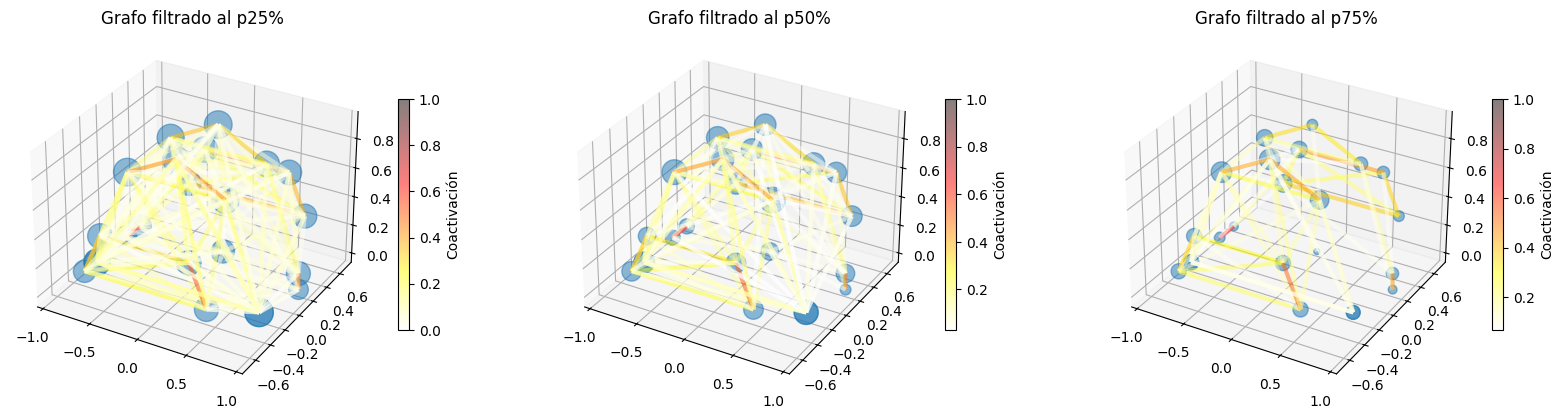

In [65]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# %matplotlib widget

fig = plt.figure(figsize=(20, 6))
axes = [fig.add_subplot(1, 3, i + 1, projection='3d') for i in range(3)]

for idx, ax in enumerate(axes):
    threshold = [p25, p50, p75][idx]
    eeg_df_filtered = eeg_df.where(eeg_df > threshold, 0)
    
    eeg_graph = nx.from_pandas_adjacency(eeg_df_filtered, create_using=nx.Graph())
    clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph)
    
    plots(ax, degree_dict, eeg_df_filtered, f"Grafo filtrado al {['p25', 'p50', 'p75'][idx]}%")
plt.show()